# Imports & General stuff

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

This notebook is dedicated to datasets analysis. 

Here we will concentrate on connecting our datasets into one dataframe that will later be used to extract meaningful information that can help us answer our research questions. 

In addition, data cleaning is performed where necessary since we will not use all the data provided. The goal of this notebook is to make data as easy as possible to use for future plotting and data story writing.

So, let's dive into our data!

In [2]:
import os
import re
import json
import time
import datetime
from functools import reduce
from itertools import product

from json import load, JSONDecodeError
from functional import pseq, seq
import pandas as pd
import pandas_profiling
import requests
import pathlib

# necessary to load the utils, which are in src
import sys
sys.path.append('../src')

from utils import file, logging
from utils.statement_handling import extract_information, safe_json_read

from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

%matplotlib inline
import utils.statement_handling as SH
reload(SH)

<module 'utils.statement_handling' from '../src/utils/statement_handling.py'>

In [3]:
def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [4]:
directory_liar_dataset = "../data/liar_dataset"
directory_statements = f"{directory_liar_dataset}/statements"
directory_visualizations = "../docs/data_insight"
directory_election_results = "../data/election_results"
directory_county_data = "../data/county_data"

# Statements

In [5]:
statements = seq(pathlib.Path(directory_statements).iterdir()).map(SH.safe_json_read)\
                               .filter(lambda x: len(x) > 0)\
                               .map(SH.extract_information)\
                               .to_pandas()

statements['statement_date'] = pd.to_datetime(statements['statement_date'])
statements.head()

ERROR:root:File ../data/liar_dataset/statements/5355.json is empty or something...
ERROR:root:File ../data/liar_dataset/statements/9.json is empty or something...


,author_name_slug,context,label,party,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,subject
0,lauren-carroll,a speech at Northwestern University,mostly-true,Democrat,2014-10-08T14:09:46,President,Barack,Illinois,Obama,The cost of health care is now the single-bigg...,2014-10-02,10039,Claim,blog post,Deficit
1,manuela-tobias,in an ad,barely-true,Republican,2017-08-25T11:24:04,,,,Senate Leadership Fund,Says Kelli Ward hosted a town hall on chemtrai...,2017-08-22,14464,Claim,blog post,Candidate Biography
2,brittany-alana-davis,remarks,mostly-true,Republican,2012-08-21T16:40:06,U.S. representative from Fort Myers,Connie,Florida,Mack,A small business in my district needed 31 diff...,2012-08-11,6501,Claim,blog post,Government regulation
3,dan-levy,a speech to the AFL-CIO Convention,barely-true,Democrat,2016-04-06T13:02:13,Presidential candidate,Hillary,New York,Clinton,When mentioning Villanova&rsquo;s buzzer-beati...,2016-04-06,12192,Claim,blog post,Sports
4,c-eugene-emery,a television interview,false,Newsmaker,2011-05-31T00:01:00,"President, Rhode Society for the Prevention of...",E.J.,Rhode Island,Finocchio,"Most of your serial killers, most of your peop...",2011-04-24,3824,Claim,blog post,Animals


In [6]:
statements.shape

(15471, 15)

# Label counts

In [7]:
truhometer_labels = ['pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true']
truhometer_labels = ['pants-fire', 'false', 'half-true', 'mostly-true', 'true']
only_truthometer_label_idx = statements['label'].isin(truhometer_labels)

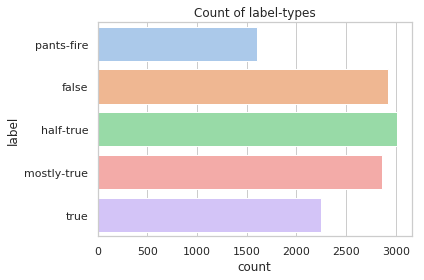

In [10]:
sns.barplot(data=group_and_count(statements.loc[only_truthometer_label_idx, :], 'label'), x='count', y='label', order=truhometer_labels)
plt.title("Count of label-types")
plt.tight_layout()
plt.savefig('../docs/images/label_counts_overall.png')

In [9]:
statements.loc[only_truthometer_label_idx,['statement_date']].describe()

,statement_date
count,12642
unique,3415
top,2011-10-11 00:00:00
freq,22
first,2000-10-01 00:00:00
last,2018-11-21 00:00:00


In [61]:
statements.loc[only_truthometer_label_idx,['statement_date']].shape

(12642, 1)

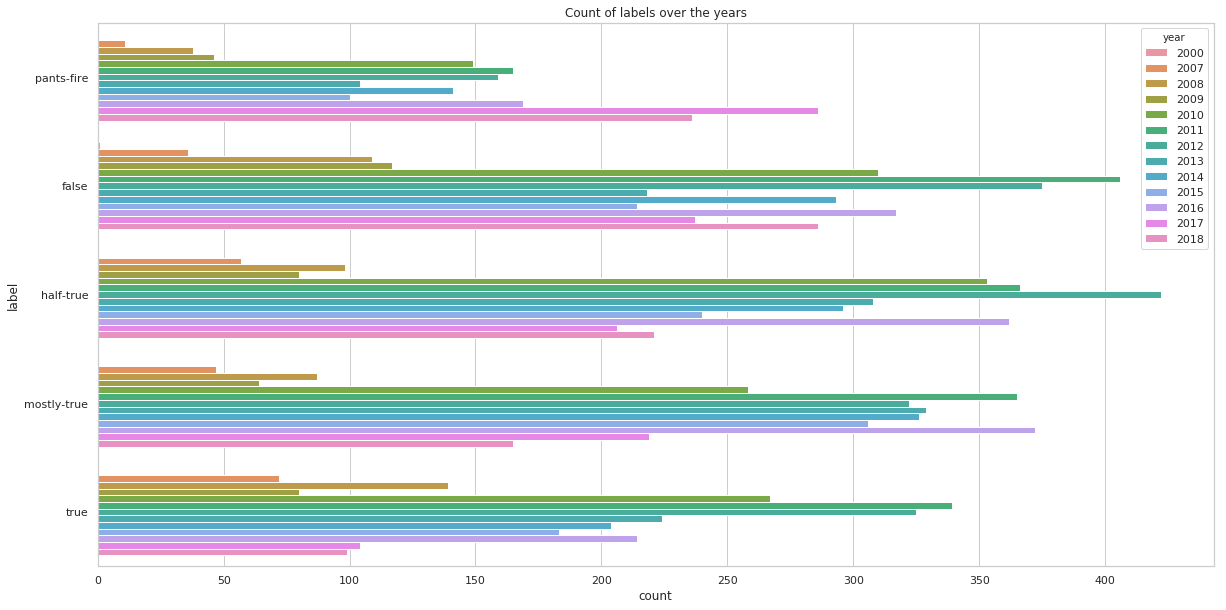

In [11]:
a = statements['statement_date'].dt.year
b = a.value_counts().index
b = sorted(list(b))

def add_year(df, year):
    df['year'] = year
    return df


d = pd.concat([add_year(group_and_count(statements.loc[(statements['statement_date'].dt.year == year) & only_truthometer_label_idx,: ], 'label'), year) for year in b])
f = plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.barplot(data=d, x='count', y='label', hue='year', order=truhometer_labels)
plt.title("Count of labels over the years")
plt.savefig('../docs/images/labels_over_years.png')

## parties

In [12]:
statements = statements.loc[only_truthometer_label_idx]

In [13]:
parties_of_interest = ['Republican', 'Democrat']

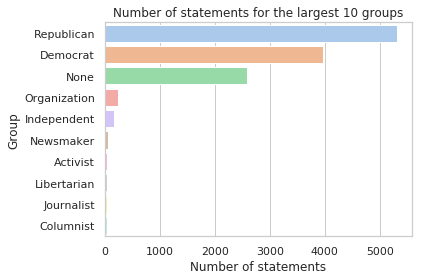

In [15]:
sns.barplot(data=group_and_count(statements, 'party')[:10], y='party', x='count')
plt.xlabel('Number of statements')
plt.ylabel('Group')
plt.title('Number of statements for the largest 10 groups')
plt.tight_layout()
plt.savefig('../docs/images/nb_statements_10_largest_groups.png')

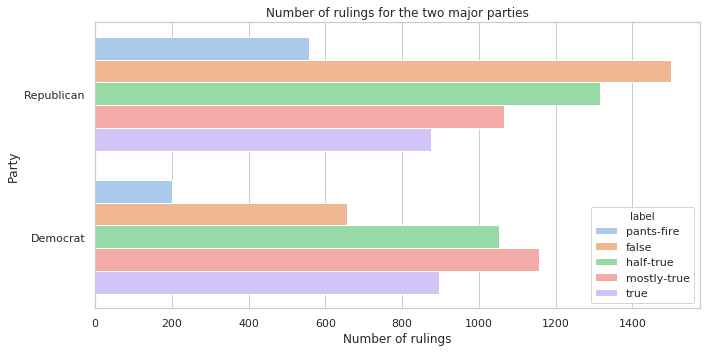

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(data=group_and_count(statements.loc[statements.party.isin(parties_of_interest), :], ['party', 'label']), y='party', x='count', hue='label', hue_order=truhometer_labels)
plt.xlabel('Number of rulings')
plt.ylabel('Party')
plt.title('Number of rulings for the two major parties')
plt.tight_layout()
plt.savefig('../docs/images/nb_rulings_for_major_parties.png')

In [19]:
statements['simple_label'] = statements.label.apply(SH.simplify_label)

In [20]:
a = group_and_count(statements.loc[statements.party.isin(parties_of_interest), :], ['party', 'simple_label']).rename(columns={'count': 'label_count'})
b = group_and_count(statements.loc[statements.party.isin(parties_of_interest), :], ['party']).rename(columns={'count': 'party_count'})
c = pd.merge(a, b)
c['in_group_pct'] = c['label_count'] / c['party_count']
c

,party,simple_label,label_count,party_count,in_group_pct
0,Republican,true,3255,5313,0.612648
1,Republican,false,2058,5313,0.387352
2,Democrat,true,3105,3962,0.783695
3,Democrat,false,857,3962,0.216305


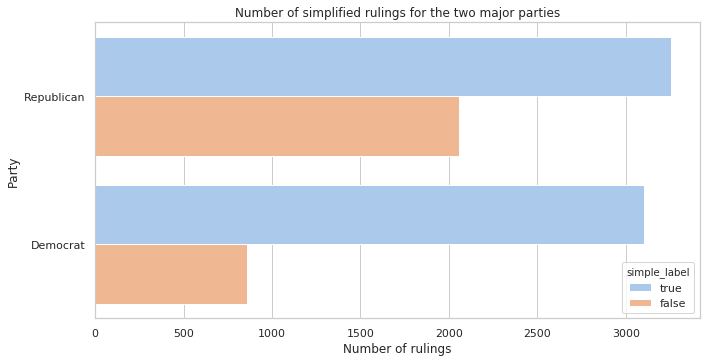

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(data=group_and_count(statements.loc[statements.party.isin(parties_of_interest), :], ['party', 'simple_label']), y='party', x='count', hue='simple_label')
plt.xlabel('Number of rulings')
plt.ylabel('Party')
plt.tight_layout()
plt.title('Number of simplified rulings for the two major parties')
plt.savefig('../docs/images/nb_simple_rulings_for_major_parties.png')

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


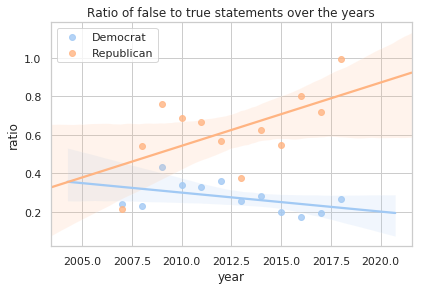

In [23]:
import numpy as np
statements['year'] = statements.statement_date.dt.year
count_per_year_and_label = pd.pivot_table(group_and_count(statements.loc[statements.party.isin(parties_of_interest)], ['year', 'party', 'simple_label']), values=['count'], columns=['simple_label'], index=['year', 'party'])

# sometimes I fucking hate multi-index...
count_per_year_and_label = pd.DataFrame(count_per_year_and_label.reset_index().values, columns=['year', 'party', 'nb_false_statements', 'nb_true_statements'])
count_per_year_and_label['ratio'] = 0
for party in parties_of_interest:
    _idx = count_per_year_and_label['party'].eq(party)
    count_per_year_and_label.loc[_idx, 'ratio'] = count_per_year_and_label.loc[_idx, 'nb_false_statements'] / count_per_year_and_label.loc[_idx, 'nb_true_statements']
    

count_per_year_and_label['ratio'] = pd.to_numeric(count_per_year_and_label['ratio'])
count_per_year_and_label['year'] = count_per_year_and_label.year.astype(np.int)

#for party in parties_of_interest:
#    sns.regplot(data=count_per_year_and_label.loc[count_per_year_and_label.party.eq(party), :], x='year', y='ratio', )

#sns.lineplot(data=count_per_year_and_label, x='year', y='ratio', hue='party')
#plt.title('Ratio of false to true statements over the years')
#plt.savefig('../docs/images/ratio_false_true_parties.png')

for party in reversed(parties_of_interest):
    sns.regplot( data=count_per_year_and_label.loc[count_per_year_and_label.party.eq(party), :], x='year', y='ratio', label=party)
    
plt.legend()
plt.tight_layout()
plt.title('Ratio of false to true statements over the years')
plt.savefig('../docs/images/ratio_false_true_parties.png')

## authors

In [26]:
statements['simple_label'] = statements['label'].apply(SH.simplify_label)
a = statements.loc[statements['party'].isin(parties_of_interest), :]

author_counts = group_and_count(a, 'author_name_slug').rename(columns={'count': 'total_count'})
author_label_counts = group_and_count(a, ['author_name_slug', 'simple_label', 'party']).rename(columns={'count': 'label_count'})

In [27]:
pd.pivot_table(a.loc[a.party.eq('Republican')], values=['label_count'], columns=['simple_label'], index='author_name_slug').reset_index()[:10]

KeyError: 'label_count'

In [28]:
_t = group_and_count(statements, 'author_name_slug', with_pct=True)
_t['pct_sum'] = np.cumsum(group_and_count(statements, 'author_name_slug', with_pct=True)['count_pct'])
(_t['pct_sum'] < 0.8).sum()

43

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1296x720 with 0 Axes>

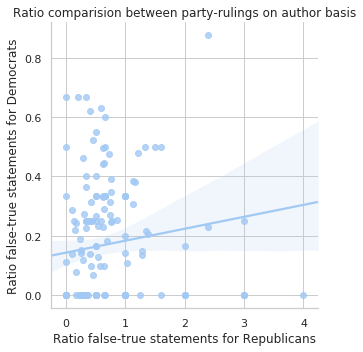

In [37]:
a = author_counts.merge(author_label_counts, on='author_name_slug')
#a['pct'] = a['label_count'] / a['total_count']
def _ratio_(df, party):
    df = df.fillna(0)
    df[f'ratio_{party}'] = df[f'false_count_{party}'] / df[f'true_count_{party}']
    return df

a = pd.merge(*[_ratio_(pd.DataFrame(pd.pivot_table(a.loc[a.party.eq(party)], 
                                values=['label_count'],
                                columns=['simple_label'],
                                index='author_name_slug').reset_index().values, 
                 columns=['author', f'false_count_{party}', f'true_count_{party}']), party) for party in parties_of_interest], on='author')[['author', 'ratio_Republican', 'ratio_Democrat']]

a = a.loc[a.ratio_Democrat.lt(a.ratio_Democrat.quantile(0.9)) & a.ratio_Republican.lt(a.ratio_Republican.quantile(0.9)), :]

f = plt.figure(figsize=(18, 10))
sns.lmplot(data=a, x='ratio_Republican', y='ratio_Democrat')
plt.title('Ratio comparision between party-rulings on author basis')
plt.xlabel('Ratio false-true statements for Republicans')
plt.ylabel('Ratio false-true statements for Democrats')
plt.tight_layout()
plt.savefig('../docs/images/ratio_comparision_author_basis.png')

In [25]:
a.mean()

label_count    2318.75
dtype: float64

In [243]:
len([pd.DataFrame(pd.pivot_table(a.loc[a.party.eq(party)], 
                                values=['label_count'],
                                columns=['simple_label'],
                                index='author_name_slug').reset_index().values, 
                 columns=['author', f'false_count_{party}', f'true_count_{party}'])
        for party in parties_of_interest])

2